<a href="https://colab.research.google.com/github/junting-huang/df4a_project/blob/main/regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preprocessing

##0.1 Data Cleaning

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read all dataframes
df_hospital = pd.read_csv('df_hospital_clean.csv')
df_price = pd.read_csv('df_price_clean.csv')
df_pop = pd.read_csv('df_population.csv')
  
# merge all three dataframes
df = pd.merge(df_hospital, df_price, on="hospital_name", how = 'inner')
df = pd.merge(df, df_pop, on="county_name", how = "inner")
  
# correct datatype
df['zip_code'] = df['zip_code'].astype('string')
df['cpt_code'] = df['cpt_code'].astype('string')
df['pcp_ratio'] = df['pcp_ratio'].astype('float')

In [3]:
# select variables
df = df[['cash_price','capacity','revenue','tps_score','pop_density','household_income',
         'unemployment','sex_ratio','children_percent','senior_percent','white_percent',
         'high_school','pcp_ratio','life_exp','uninsured','cpt_code','urban','ownership',
         'system','hospital_name']]

# create the dataframe primary key
df = df.reset_index()
df = df.rename(columns={'index':'price_id'})
df['price_id'] = df['price_id'].astype('string')
df_dash = df

# transforms cpt code to a categorical variable 
service_cat = {'45378':'surgery','59409':'surgery','70450':'high-end test','70551':'high-end test',
               '85025':'low-end test','85027':'low-end test','99203':'visit'}
df['service_cat']= df['cpt_code'].map(service_cat)

# drop n.a. variables
df = df.dropna()
df_copy = df
df = df.drop(['urban','ownership','system','hospital_name','service_cat'],axis=1)

## 0.2 Feature Scaling



"Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step." [1]

"Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation." [2]

[1]https://en.wikipedia.org/wiki/Feature_scaling \
[2]https://scikit-learn.org/stable/modules/preprocessing.html

In [4]:
# create the new dataframes based on the cpt codes 
df_colon = df.loc[df['cpt_code']== '45378']
df_delivery = df.loc[df['cpt_code'] == '59409']
df_headCT = df.loc[df['cpt_code'] == '70450']
df_brainMRI = df.loc[df['cpt_code'] == '70551']
df_bloodCount = df.loc[df['cpt_code'] == '85025']
df_bloodCountDiff = df.loc[df['cpt_code'] == '85027']
df_visit = df.loc[df['cpt_code'] == '99203']

ls_cpt = [df_colon, df_delivery, df_headCT, df_brainMRI, df_bloodCount, df_bloodCountDiff, df_visit]

In [5]:
# normalization or standardization in order to scale all procedures to a comparable range 
from sklearn.preprocessing import StandardScaler

scaler_1 = StandardScaler()
df_st = pd.DataFrame()

for i in ls_cpt:
  it = scaler_1.fit_transform(i.drop('price_id',axis=1))
  it = pd.DataFrame(data=it, columns=df.columns[1:18])
  im = pd.concat([i['price_id'].reset_index(drop=True), it.reset_index(drop=True)], axis=1)
  df_st = df_st.append(im)

df_st

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code
0,11,0.276290,0.883871,0.613576,0.613810,-0.237640,-0.145164,-1.215592,-0.578740,0.492138,-0.875982,-0.238372,1.126136,-0.766368,0.547387,-0.856959,0.0
1,23,0.101763,0.690565,0.158453,0.033835,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0
2,36,-0.267563,0.651904,0.360007,0.268293,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0
3,48,-0.115894,0.063396,-0.238804,0.231273,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0
4,55,1.177955,1.519632,0.769618,0.564450,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,538,0.473358,-0.807121,-0.532377,-1.293818,-0.696202,-0.496475,0.055388,0.465258,0.657256,0.136859,0.788922,-0.995334,0.528299,0.018647,0.219529,0.0
54,554,0.473358,-0.711437,-0.523453,1.639625,-0.695675,-0.681812,1.126224,-0.113508,-0.228509,1.168398,0.781777,0.513931,-0.561735,0.319064,0.219529,0.0
55,560,0.473358,-0.807121,-0.579669,-1.293818,-0.642939,1.054504,-0.918099,0.519517,0.408135,-0.064131,0.860373,0.891247,0.842493,1.100148,-0.841526,0.0
56,566,0.473358,-0.567913,-0.600192,-1.293818,-0.713342,-0.935431,-0.334007,0.429085,0.359404,0.552416,0.846083,-0.618018,1.747824,-0.101520,1.280583,0.0


## 0.3 Dummy Variables (Categorical Features)


"Dummy Variables in Regression
In this lesson, we show how to analyze regression equations when one or more independent variables are categorical. The key to the analysis is to express categorical variables as dummy variables.

What is a Dummy Variable?
A dummy variable (aka, an indicator variable) is a numeric variable that represents categorical data, such as gender, race, political affiliation, etc.

Technically, dummy variables are dichotomous, quantitative variables. Their range of values is small; they can take on only two quantitative values. As a practical matter, regression results are easiest to interpret when dummy variables are limited to two specific values, 1 or 0. Typically, 1 represents the presence of a qualitative attribute, and 0 represents the absence." [1]

[1] https://stattrek.com/multiple-regression/dummy-variables.aspx

In [6]:
# create dummy variables
df_copycat = df_copy.sort_values(by=['cpt_code','price_id'])
cat_variables = df_copycat[['ownership', 'service_cat']]
cat_dummies = pd.get_dummies(cat_variables)
df_cat = pd.concat([df_st.reset_index(drop=True), cat_dummies.reset_index(drop=True)], axis=1)

df_cat

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code,"ownership_Governmental, County","ownership_Governmental, Other","ownership_Proprietary, Corporation","ownership_Voluntary Nonprofit, Church","ownership_Voluntary Nonprofit, Other",service_cat_high-end test,service_cat_low-end test,service_cat_surgery,service_cat_visit
0,11,0.276290,0.883871,0.613576,0.613810,-0.237640,-0.145164,-1.215592,-0.578740,0.492138,-0.875982,-0.238372,1.126136,-0.766368,0.547387,-0.856959,0.0,0,0,0,0,1,0,0,1,0
1,23,0.101763,0.690565,0.158453,0.033835,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0,0,0,0,0,1,0,0,1,0
2,36,-0.267563,0.651904,0.360007,0.268293,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0,0,0,0,0,1,0,0,1,0
3,48,-0.115894,0.063396,-0.238804,0.231273,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0,0,0,0,0,1,0,0,1,0
4,55,1.177955,1.519632,0.769618,0.564450,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,538,0.473358,-0.807121,-0.532377,-1.293818,-0.696202,-0.496475,0.055388,0.465258,0.657256,0.136859,0.788922,-0.995334,0.528299,0.018647,0.219529,0.0,0,0,0,0,1,0,0,0,1
473,554,0.473358,-0.711437,-0.523453,1.639625,-0.695675,-0.681812,1.126224,-0.113508,-0.228509,1.168398,0.781777,0.513931,-0.561735,0.319064,0.219529,0.0,0,0,0,0,1,0,0,0,1
474,560,0.473358,-0.807121,-0.579669,-1.293818,-0.642939,1.054504,-0.918099,0.519517,0.408135,-0.064131,0.860373,0.891247,0.842493,1.100148,-0.841526,0.0,0,0,0,0,1,0,0,0,1
475,566,0.473358,-0.567913,-0.600192,-1.293818,-0.713342,-0.935431,-0.334007,0.429085,0.359404,0.552416,0.846083,-0.618018,1.747824,-0.101520,1.280583,0.0,0,0,0,0,1,0,0,0,1


In [24]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   price_id                               477 non-null    string 
 1   cash_price                             477 non-null    float64
 2   capacity                               477 non-null    float64
 3   revenue                                477 non-null    float64
 4   tps_score                              477 non-null    float64
 5   pop_density                            477 non-null    float64
 6   household_income                       477 non-null    float64
 7   unemployment                           477 non-null    float64
 8   sex_ratio                              477 non-null    float64
 9   children_percent                       477 non-null    float64
 10  senior_percent                         477 non-null    float64
 11  white_

## 0.4 Correlation Matrix

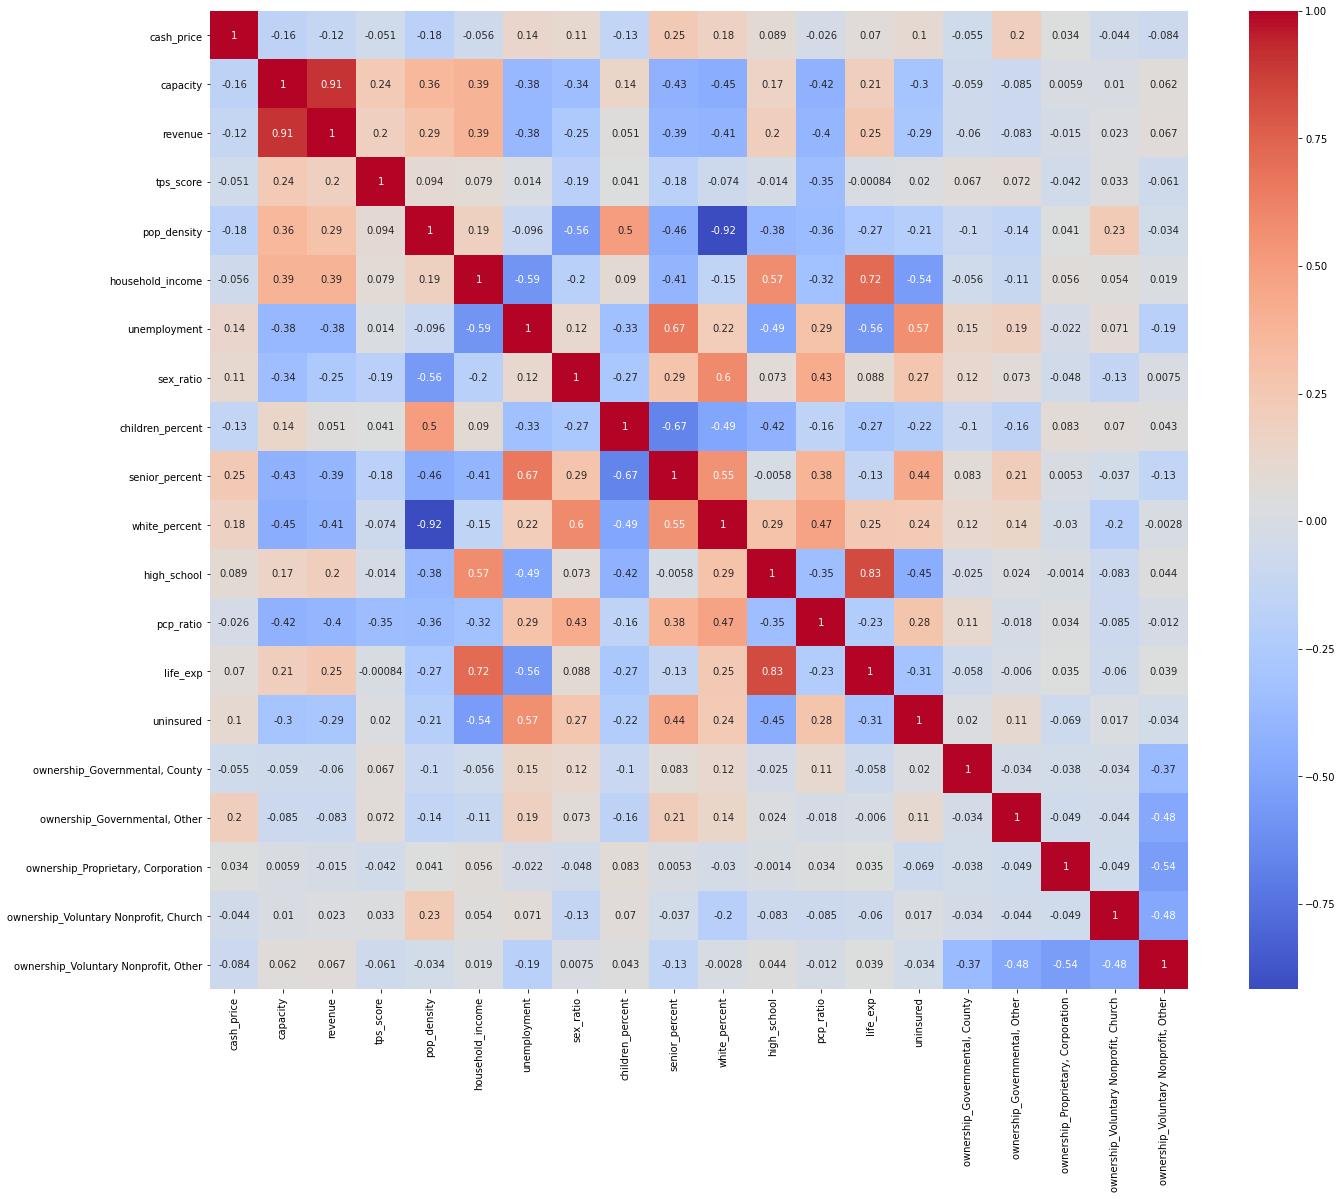

In [12]:
# Correlation matrix (change the dataframe)
corr_mat=df_cat.drop(['service_cat_high-end test','service_cat_low-end test','service_cat_surgery','service_cat_visit','cpt_code'],axis=1).corr(method='pearson')
plt.figure(figsize=(22,18))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='coolwarm')

In [ ]:
# pairplot
df_pair = df_st[['cash_price','capacity','pop_density','white_percent','senior_percent','household_income','uninsured','pcp_ratio']]
sns.pairplot(df_pair)

## 0.5 PCA (Principal component analysis)

In [26]:
# PCA Analysis
# X is the variables, y is the target (change the variables, or the dataframe below for cpt-code-specific results) 
X = df_cat.drop(['cash_price','price_id'], axis=1)
y = df_cat['cash_price']

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   capacity                               477 non-null    float64
 1   revenue                                477 non-null    float64
 2   tps_score                              477 non-null    float64
 3   pop_density                            477 non-null    float64
 4   household_income                       477 non-null    float64
 5   unemployment                           477 non-null    float64
 6   sex_ratio                              477 non-null    float64
 7   children_percent                       477 non-null    float64
 8   senior_percent                         477 non-null    float64
 9   white_percent                          477 non-null    float64
 10  high_school                            477 non-null    float64
 11  pcp_ra

In [103]:
from sklearn.decomposition import PCA
# The PCA model
pca = PCA(n_components=2) # estimate only 2 PCs
X_new = pca.fit_transform(X) # project the original data into the PCA space

No handles with labels found to put in legend.


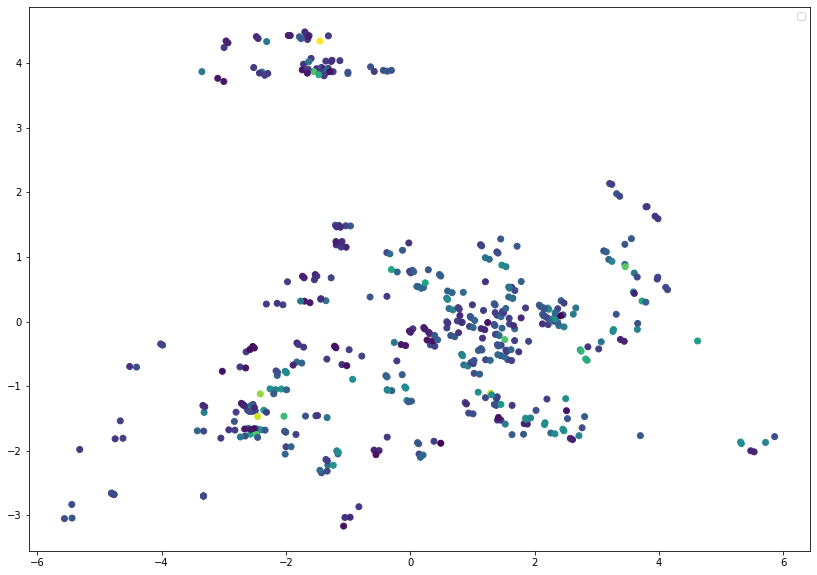

In [98]:
plt.figure(figsize=(14, 10))
plt.scatter(X_new[:,0], X_new[:,1], c=y)
plt.legend()

In [79]:
print(pca.explained_variance_ratio_)

[0.32989958 0.21676874]


In [80]:
print(abs( pca.components_ ))

[[3.30808450e-01 3.13176981e-01 1.06129389e-01 2.68297676e-01
  2.99185213e-01 3.12793697e-01 2.46652273e-01 2.00876231e-01
  3.46011617e-01 3.06733055e-01 1.29495745e-01 2.93279431e-01
  1.57809436e-01 2.80443952e-01 0.00000000e+00 9.25794156e-03
  1.50184370e-02 3.46005386e-03 7.68260472e-03 1.31337200e-02
  3.07180022e-05 6.38010197e-05 3.47002859e-06 3.65530461e-05]
 [4.83313685e-03 4.48058734e-02 4.67010435e-02 3.60740815e-01
  2.76928503e-01 2.15280490e-01 2.04330936e-01 2.97795113e-01
  9.29549428e-02 3.39824829e-01 4.93875939e-01 8.07873377e-03
  4.70201904e-01 1.50185965e-01 4.03896783e-28 1.99740355e-03
  5.88903221e-03 9.55698301e-04 1.71857542e-02 1.02550167e-02
  2.06981975e-05 6.35618552e-05 3.80298456e-05 4.62302071e-05]]


In [81]:
pca_x = abs( pca.components_ )

<BarContainer object of 24 artists>

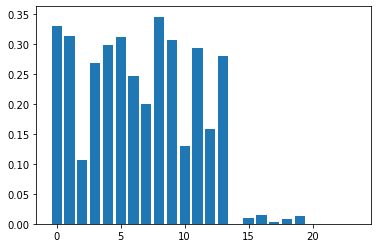

In [82]:
plt.bar(range(24),pca_x[0])

<BarContainer object of 24 artists>

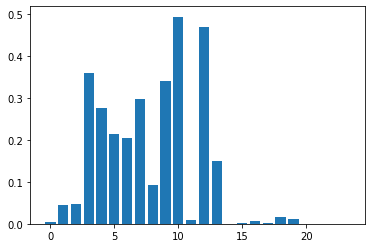

In [83]:
plt.bar(range(24),pca_x[1])

In [84]:
df_pca = pd.DataFrame(pca_x, columns = X.columns)

In [85]:
df_pcat = df_pca.transpose()

In [87]:
df_pcat.sort_values(by=0,ascending=False)

,0,1
senior_percent,0.346012,9.295494e-02
capacity,0.330808,4.833137e-03
revenue,0.313177,4.480587e-02
unemployment,0.312794,2.152805e-01
white_percent,0.306733,3.398248e-01
household_income,0.299185,2.769285e-01
pcp_ratio,0.293279,8.078734e-03
uninsured,0.280444,1.501860e-01
pop_density,0.268298,3.607408e-01
sex_ratio,0.246652,2.043309e-01


In [122]:
df_pcat.sort_values(by=1,ascending=False)

,0,1
high_school,0.129496,4.938759e-01
life_exp,0.157809,4.702019e-01
pop_density,0.268298,3.607408e-01
white_percent,0.306733,3.398248e-01
children_percent,0.200876,2.977951e-01
household_income,0.299185,2.769285e-01
unemployment,0.312794,2.152805e-01
sex_ratio,0.246652,2.043309e-01
uninsured,0.280444,1.501860e-01
senior_percent,0.346012,9.295494e-02


#1. Regression Models


"Model selection and evaluation using tools, such as model_selection.GridSearchCV and model_selection.cross_val_score, take a scoring parameter that controls what metric they apply to the estimators evaluated.

For the most common use cases, you can designate a scorer object with the scoring parameter; the table below shows all possible values. All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric."

[1] https://scikit-learn.org/stable/modules/model_evaluation.html

## 1.1 Preliminary Model Selection


In [13]:
from sklearn import datasets, linear_model
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

In [ ]:
# regression model list
regr_list ={'Linear Regression': linear_model.LinearRegression(),
            'Bayesian Regression': linear_model.BayesianRidge(),
            'Least Angle Regression': linear_model.Lars(),
            'Stochastic Gradient Descent': SGDRegressor(),
            'K-Nearest Neighbors': neighbors.KNeighborsRegressor(),
            'Support Vector Machine': svm.SVR(),
            'Decision Tree': tree.DecisionTreeRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor()}

In [ ]:
# X is the variables, y is the target (change the variables, or the dataframe below for cpt-code-specific results) 
X = df_cat.drop('cash_price', axis=1)
y = df_cat['cash_price']

# split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for i in regr_list:
  regr = regr_list[i]
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)

  score_1 = r2_score(y_test, y_pred)
  score_2 = mean_absolute_error(y_test, y_pred)
  score_3 = mean_squared_error(y_test, y_pred)

  print(f" {i} \n the r2_score is {score_1},\n the mean_absolute_error is {score_2} ,\n the mean_squared_error is {score_3}." )
  print()

 Linear Regression 
 the r2_score is 0.11361077683164944,
 the mean_absolute_error is 0.7531478405109646 ,
 the mean_squared_error is 0.9829159385956672.

 Bayesian Regression 
 the r2_score is 0.062199653962176416,
 the mean_absolute_error is 0.7875825424010422 ,
 the mean_squared_error is 1.0399256706283722.

 Least Angle Regression 
 the r2_score is 0.117317355970733,
 the mean_absolute_error is 0.7515591723025289 ,
 the mean_squared_error is 0.9788057174667947.

 Stochastic Gradient Descent 
 the r2_score is -1.1464629122965068e+27,
 the mean_absolute_error is 30982412436205.363 ,
 the mean_squared_error is 1.2713113382370364e+27.

 K-Nearest Neighbors 
 the r2_score is 0.2582913269037258,
 the mean_absolute_error is 0.6374665526410865 ,
 the mean_squared_error is 0.8224798514303533.

 Support Vector Machine 
 the r2_score is 0.013462992238781779,
 the mean_absolute_error is 0.7349841047892305 ,
 the mean_squared_error is 1.0939696959275962.

 Decision Tree 
 the r2_score is 0.2063

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=9.874e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 9.186e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=9.884e-06, with an active set of 22 regressors, and the smallest cholesky pivot element being 6.409e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


 Random Forest 
 the r2_score is 0.4423228272167661,
 the mean_absolute_error is 0.5538699205565092 ,
 the mean_squared_error is 0.6184075430884397.

 Neural Network 
 the r2_score is 0.05431799139467752,
 the mean_absolute_error is 0.736648201927717 ,
 the mean_squared_error is 1.048665636726489.



## 1.2 K-Fold Cross-Validation

"Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split." [3]

[1] https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 \
[2]https://scikit-learn.org/stable/modules/cross_validation.html#k-fold \
[3]https://machinelearningmastery.com/k-fold-cross-validation/

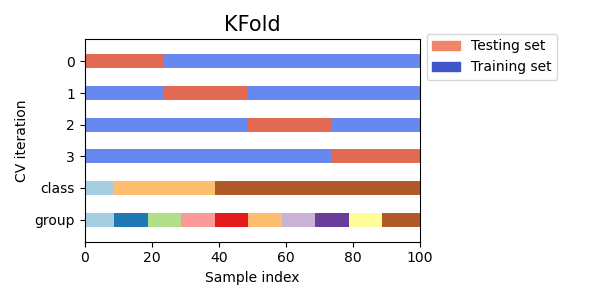

In [ ]:
regr_shortlist ={'Linear Regression': linear_model.LinearRegression(),
            'Support Vector Machine': svm.SVR(),
            'K-Nearest Neighbors': neighbors.KNeighborsRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor()}

def get_r2 (model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return r2_score(y_test, y_pred)

In [ ]:
from sklearn.model_selection import KFold

lr_score = []
br_score = []
knn_score = []
rf_score = []
nn_score = []

# change the number of folds here, 5 or 10 are common
kf = KFold(n_splits=10)
for train, test in kf.split(df_cat):
  X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]

  lr_score.append(get_r2(linear_model.LinearRegression(), X_train, X_test, y_train, y_test))
  br_score.append(get_r2(linear_model.BayesianRidge(), X_train, X_test, y_train, y_test))
  knn_score.append(get_r2(neighbors.KNeighborsRegressor(), X_train, X_test, y_train, y_test))
  rf_score.append(get_r2(RandomForestRegressor(), X_train, X_test, y_train, y_test))
  nn_score.append(get_r2(MLPRegressor(), X_train, X_test, y_train, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# r2 results
lr_av = sum(lr_score)/len(lr_score)
br_av = sum(br_score)/len(br_score)
knn_av = sum(knn_score)/len(knn_score)
rf_av = sum(rf_score)/len(rf_score)
nn_av = sum(nn_score)/len(nn_score)

print('R Squared With K-Fold Cross-Validation')
print(f'Linear Regression Average: {lr_av}')
print(f'Support Vector Machine: {br_av}')
print(f'Nearest Neighbors Average: {knn_av}')
print(f'Random Forest Average: {rf_av}')
print(f'Neural Network Average: {nn_av}')

R Squared With K-Fold Cross-Validation
Linear Regression Average: 0.07547678187677859
Support Vector Machine: 0.06667921393632997
Nearest Neighbors Average: 0.31161114773956045
Random Forest Average: 0.4154349988453495
Neural Network Average: 0.0995069182551505


## 1.3 Model Optimization

Hyperparameter Tuning the Random Forest

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)




**Accuracy Rate = 1 - Absolute Mean Error / (Mean Cash Price - Min Cash Price)**

In [ ]:
# Avarage Cash Price - Min Cash Price
y_exp = np.mean(y)
y_min = np.min(y)
y_exp - y_min

1.7206966095412397

### 1.3.1 Randomized Search 

THIS SECTION REQUIRES AT LEAST 20 MIN TO RUN

IT HELPS TO NARROW DOWN THE RANGE OF BEST PARAMETERS, BUT WE ALREADY HAVE THEM SO SKIP TO THE GRID SEARCH IN 1.3.2

"Random Search
Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values. To optimise with random search, the function is evaluated at some number of random configurations in the parameter space. 

The chances of finding the optimal parameter are comparatively higher in random search because of the random search pattern where the model might end up being trained on the optimised parameters without any aliasing. Random search works best for lower dimensional data since the time taken to find the right set is less with less number of iterations. Random search is the best parameter search technique when there are less number of dimensions. In the paper Random Search for Hyper-Parameter Optimization by Bergstra and Bengio, the authors show empirically and theoretically that random search is more efficient for parameter optimization than grid search.
" [1]

[1]https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318


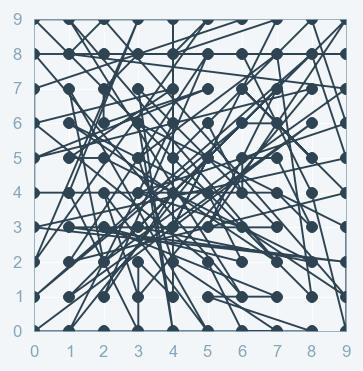

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

In [ ]:
rf_random.best_params_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * (np.mean(abs(errors / 1.7206966095412397)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * abs(random_accuracy - base_accuracy) / abs(base_accuracy)))

### 1.3.2 Grid Search

"Grid Search
In Grid Search, we try every combination of a preset list of values of the hyper-parameters and evaluate the model for each combination. The pattern followed here is similar to the grid, where all the values are placed in the form of a matrix. Each set of parameters is taken into consideration and the accuracy is noted. Once all the combinations are evaluated, the model with the set of parameters which give the top accuracy is considered to be the best." [1]

[1] https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318


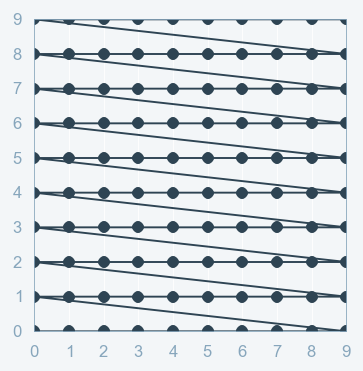

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100],
    'max_features': [2],
    'min_samples_leaf': [1],
    'min_samples_split': [3],
    'n_estimators': [1000, 1400]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X, y)
grid_search.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s finished


{'bootstrap': False,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * (np.mean(abs(errors / 1.7206966095412397)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * abs(grid_accuracy - base_accuracy) / abs(base_accuracy)))

Model Performance
Average Error: 0.5441 degrees.
Accuracy = 68.38%.

Model Performance
Average Error: 0.0875 degrees.
Accuracy = 94.91%.

Improvement of 38.81%.


In [ ]:
# compare this with other base models
print('Linear Regression')
model_1 = linear_model.LinearRegression()
model_1.fit(X_train, y_train)
evaluate(model_1, X_test, y_test)

print('Support Vector Machine')
model_2 = svm.SVR()
model_2.fit(X_train, y_train)
evaluate(model_2,X_test, y_test)

print('KNN')
model_3 = neighbors.KNeighborsRegressor()
model_3.fit(X_train, y_train)
evaluate(model_3, X_test, y_test)

print('Neural Network')
model_4 = MLPRegressor()
model_4.fit(X_train, y_train)
evaluate(model_4, X_test, y_test)

Linear Regression
Model Performance
Average Error: 0.7076 degrees.
Accuracy = 58.88%.

Support Vector Machine
Model Performance
Average Error: 0.5768 degrees.
Accuracy = 66.48%.

KNN
Model Performance
Average Error: 0.6113 degrees.
Accuracy = 64.47%.

Neural Network
Model Performance
Average Error: 0.5988 degrees.
Accuracy = 65.20%.



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


65.2029092743396

# 2. Prediction

## 2.1 Imputation for the Missing Revenue data

In [ ]:
# revenue data missing
df_dash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    string 
 1   cash_price        500 non-null    float64
 2   capacity          590 non-null    int64  
 3   revenue           562 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    int64  
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    string 
 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_2 = MinMaxScaler()

df_dash_imp = df_dash.drop(['cpt_code','urban','ownership','type','system','hospital_name','service_cat','cash_price'],axis=1)
df_dash_imp = pd.DataFrame(scaler_2.fit_transform(df_dash_imp), columns = df_dash_imp.columns)
df_dash_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           562 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
dtypes: float64(15)
memory usage: 69.3 KB


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_dash_imp = pd.DataFrame(imputer.fit_transform(df_dash_imp),columns = df_dash_imp.columns)
df_dash_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           590 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
dtypes: float64(15)
memory usage: 69.3 KB


In [ ]:
df_dash_impd = scaler_2.inverse_transform(df_dash_imp)
df_dash_impd = pd.DataFrame(df_dash_impd, columns = df_dash_imp.columns)
df_dash_impd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           590 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
dtypes: float64(15)
memory usage: 69.3 KB


In [ ]:
df_dash_prep = df_dash.copy()
df_dash_prep['revenue'] = df_dash_impd['revenue'].values

In [ ]:
df_dash_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    string 
 1   cash_price        500 non-null    float64
 2   capacity          590 non-null    int64  
 3   revenue           590 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    int64  
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    string 
 1

## 2.2 DataFrame Preparation

In [ ]:
df_dash_prep = df_dash_prep.drop(['urban','ownership','type','system','hospital_name','service_cat'],axis=1)
df_dash_prep.info()

In [ ]:
# create the new dataframes based on the cpt codes 
df_dash_prep_colon = df_dash_prep.loc[df_dash_prep['cpt_code']== '45378']
df_dash_prep_delivery = df_dash_prep.loc[df_dash_prep['cpt_code'] == '59409']
df_dash_prep_headCT = df_dash_prep.loc[df_dash_prep['cpt_code'] == '70450']
df_dash_prep_brainMRI = df_dash_prep.loc[df_dash_prep['cpt_code'] == '70551']
df_dash_prep_bloodCount = df_dash_prep.loc[df_dash_prep['cpt_code'] == '85025']
df_dash_prep_bloodCountDiff = df_dash_prep.loc[df_dash_prep['cpt_code'] == '85027']
df_dash_prep_visit = df_dash_prep.loc[df_dash_prep['cpt_code'] == '99203']

ls_cpt_prep = [df_dash_prep_colon, df_dash_prep_delivery, df_dash_prep_headCT, df_dash_prep_brainMRI, df_dash_prep_bloodCount, df_dash_prep_bloodCountDiff, df_dash_prep_visit]

# create a new scaler for each cpt code 
scaler_p1 = StandardScaler()
scaler_p2 = StandardScaler()
scaler_p3 = StandardScaler()
scaler_p4 = StandardScaler()
scaler_p5 = StandardScaler()
scaler_p6 = StandardScaler()
scaler_p7 = StandardScaler()

ls_sc_prep = [scaler_p1,scaler_p2,scaler_p3,scaler_p4,scaler_p5,scaler_p6,scaler_p7]

In [ ]:
df_st_prep=pd.DataFrame()

for i in range(7):
  itp = ls_sc_prep[i].fit_transform(ls_cpt_prep[i].drop('price_id',axis=1))
  itp = pd.DataFrame(data=itp, columns=df.columns[1:18])
  imp = pd.concat([ls_cpt_prep[i]['price_id'].reset_index(drop=True), itp.reset_index(drop=True)], axis=1)
  df_st_prep = df_st_prep.append(imp)

df_st_prep

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code
0,11,0.093100,0.939600,0.660683,0.630996,-0.263714,-0.163606,-1.227682,-0.566811,0.483950,-0.879977,-0.208691,1.130828,-0.759509,0.557778,-0.832050,0.0
1,23,-0.036379,0.743809,0.195239,0.066378,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0
2,36,-0.310377,0.704651,0.401364,0.294628,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0
3,41,1.294202,-0.866030,-0.587810,-1.231042,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0
4,48,-0.197856,0.108575,-0.211027,0.258588,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,538,0.473358,-0.824440,-0.559624,-1.305861,-0.754512,-0.522099,0.071447,0.521106,0.622812,0.179546,0.842427,-0.940235,0.588515,0.014952,0.244600,0.0
58,554,0.473358,-0.731671,-0.550671,1.674527,-0.754007,-0.696725,1.154263,-0.064327,-0.267020,1.232640,0.835576,0.508077,-0.507860,0.304642,0.244600,0.0
59,560,0.473358,-0.824440,-0.607077,-1.305861,-0.703534,0.939244,-0.912932,0.575990,0.372547,-0.025643,0.910934,0.870156,0.904537,1.057837,-0.838628,0.0
60,566,0.473358,-0.592519,-0.627670,-1.305861,-0.770915,-0.935686,-0.322305,0.484516,0.323593,0.603787,0.897233,-0.578157,1.815134,-0.100924,1.327827,0.0


In [ ]:
# create dummy variables
df_dashcat = df_dash.sort_values(by=['cpt_code','price_id'])
cat_variables = df_dashcat[['ownership', 'service_cat']]
cat_dummies = pd.get_dummies(cat_variables)
df_cat_prep = pd.concat([df_st_prep.reset_index(drop=True), cat_dummies.reset_index(drop=True)], axis=1)
df_cat_prep

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code,"ownership_Governmental, County","ownership_Governmental, Other","ownership_Proprietary, Corporation","ownership_Voluntary Nonprofit, Church","ownership_Voluntary Nonprofit, Other",service_cat_high-end test,service_cat_low-end test,service_cat_surgery,service_cat_visit
0,11,0.093100,0.939600,0.660683,0.630996,-0.263714,-0.163606,-1.227682,-0.566811,0.483950,-0.879977,-0.208691,1.130828,-0.759509,0.557778,-0.832050,0.0,0,0,0,0,1,0,0,1,0
1,23,-0.036379,0.743809,0.195239,0.066378,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0,0,0,0,0,1,0,0,1,0
2,36,-0.310377,0.704651,0.401364,0.294628,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0,0,0,0,0,1,0,0,1,0
3,41,1.294202,-0.866030,-0.587810,-1.231042,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0,0,0,0,0,1,0,0,1,0
4,48,-0.197856,0.108575,-0.211027,0.258588,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,538,0.473358,-0.824440,-0.559624,-1.305861,-0.754512,-0.522099,0.071447,0.521106,0.622812,0.179546,0.842427,-0.940235,0.588515,0.014952,0.244600,0.0,0,0,0,0,1,0,0,0,1
586,554,0.473358,-0.731671,-0.550671,1.674527,-0.754007,-0.696725,1.154263,-0.064327,-0.267020,1.232640,0.835576,0.508077,-0.507860,0.304642,0.244600,0.0,0,0,0,0,1,0,0,0,1
587,560,0.473358,-0.824440,-0.607077,-1.305861,-0.703534,0.939244,-0.912932,0.575990,0.372547,-0.025643,0.910934,0.870156,0.904537,1.057837,-0.838628,0.0,0,0,0,0,1,0,0,0,1
588,566,0.473358,-0.592519,-0.627670,-1.305861,-0.770915,-0.935686,-0.322305,0.484516,0.323593,0.603787,0.897233,-0.578157,1.815134,-0.100924,1.327827,0.0,0,0,0,0,1,0,0,0,1


## 2.3 Use New X for Prediction

In [ ]:
X_new = df_cat_prep.drop('cash_price', axis=1)
y_new = best_grid.predict(X_new)

In [ ]:
# add prediction to the dataframe
df_dash_final = df_cat_prep
df_dash_final['cash_price_pred'] = y_new
df_dash_final[['cash_price','cash_price_pred']]

,cash_price,cash_price_pred
0,0.093100,0.806760
1,-0.036379,0.100019
2,-0.310377,-0.244756
3,1.294202,0.983417
4,-0.197856,0.672581
...,...,...
585,0.473358,0.190386
586,0.473358,0.354315
587,0.473358,0.208316
588,0.473358,0.246641


In [ ]:
# add back cpt code and reverse transform
df_cpt_extract = df_dash.sort_values(by=['cpt_code','price_id'])['cpt_code']
df_cpt_extract = df_cpt_extract.reset_index()
df_cpt_extract = df_cpt_extract['cpt_code']
df_dash_final['cpt_code'] = df_cpt_extract

## 2.4 Inverse Transformation

In [ ]:
# replace cash with pred
df_dash_final['cash_price'] = df_dash_final['cash_price_pred']

# unify the shape of df_dash_final and df_st_prep
to_drop = set(df_dash_final.columns) - set(df_st_prep.columns)
df_dash_final = df_dash_final.drop(columns=to_drop)
df_dash_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    string 
 1   cash_price        590 non-null    float64
 2   capacity          590 non-null    float64
 3   revenue           590 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    float64
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    string 
dt

In [ ]:
df_dash_final['cpt_code'] = df_dash_final['cpt_code'].astype('float')

In [ ]:
scl = [scaler_p1, scaler_p2, scaler_p3, scaler_p4, scaler_p5, scaler_p6, scaler_p7]
final_cpt_list = df_dash_final['cpt_code'].unique()

df_inverse_final = pd.DataFrame()

for i in range(7):
  df_inverse = pd.DataFrame()
  df_inverse = df_dash_final.loc[df_dash_final['cpt_code'] == final_cpt_list[i]]
  df_inverse = scl[i].inverse_transform(df_inverse.drop('price_id',axis=1))
  df_inverse = pd.DataFrame(data=df_inverse)
  imi = pd.concat([ls_cpt_prep[i]['price_id'].reset_index(drop=True),df_inverse.reset_index(drop=True)], axis=1)
  df_inverse_final = df_inverse_final.append(imi)

df_inverse_final

,price_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,11,4566.600795,415.0,1.920000e+09,3.875000e+01,182.1,56700.0,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,90756.0
1,23,2360.724791,370.0,1.220000e+09,2.700000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
2,36,1284.615439,361.0,1.530000e+09,3.175000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
3,41,5117.978954,0.0,4.234000e+07,0.000000e+00,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
4,48,4147.801968,224.0,6.090000e+08,3.100000e+01,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,538,118.407571,25.0,2.390000e+08,3.552714e-15,22.5,51800.0,0.042,101.4,0.183606,0.197775,96.5,0.88,107.08,77.9,0.07,198406.0
58,554,126.745250,45.0,2.490000e+08,5.950000e+01,22.7,49900.0,0.053,98.2,0.167204,0.242554,96.4,0.92,57.92,78.4,0.07,198406.0
59,560,119.319517,25.0,1.860000e+08,3.552714e-15,42.7,67700.0,0.032,101.7,0.178993,0.189050,97.5,0.93,121.25,79.7,0.06,198406.0
60,566,121.268788,75.0,1.630000e+08,3.552714e-15,16.0,47300.0,0.038,101.2,0.178090,0.215814,97.3,0.89,162.08,77.7,0.08,198406.0


In [ ]:
df_inverse_final.columns = df_dash_final.columns
df_inverse_final

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code
0,11,4566.600795,415.0,1.920000e+09,3.875000e+01,182.1,56700.0,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,90756.0
1,23,2360.724791,370.0,1.220000e+09,2.700000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
2,36,1284.615439,361.0,1.530000e+09,3.175000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
3,41,5117.978954,0.0,4.234000e+07,0.000000e+00,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
4,48,4147.801968,224.0,6.090000e+08,3.100000e+01,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,538,118.407571,25.0,2.390000e+08,3.552714e-15,22.5,51800.0,0.042,101.4,0.183606,0.197775,96.5,0.88,107.08,77.9,0.07,198406.0
58,554,126.745250,45.0,2.490000e+08,5.950000e+01,22.7,49900.0,0.053,98.2,0.167204,0.242554,96.4,0.92,57.92,78.4,0.07,198406.0
59,560,119.319517,25.0,1.860000e+08,3.552714e-15,42.7,67700.0,0.032,101.7,0.178993,0.189050,97.5,0.93,121.25,79.7,0.06,198406.0
60,566,121.268788,75.0,1.630000e+08,3.552714e-15,16.0,47300.0,0.038,101.2,0.178090,0.215814,97.3,0.89,162.08,77.7,0.08,198406.0


In [ ]:
df_inverse_final = df_inverse_final.rename(columns={'cash_price':'cash_price_pred'})

In [ ]:
df_inverse_final.to_csv('df_inverse_final.csv')

## 2.5 Create the Final Dashboard Dataframe

In [ ]:
df_dashboard = pd.read_csv('df_dashboard.csv')

In [ ]:
df_dashboard['price_id'] = df_dashboard['price_id'].astype('string')

In [ ]:
df_dashboard_final = pd.merge(df_dashboard, df_inverse_final[['price_id','cash_price_pred']], on='price_id', how='inner')
df_dashboard_final

,price_id,hospital_name,system,facility,county_name,zip_code,capacity,revenue,ownership,urban,type,tps_score,cpt_code,description,gross_charge,cash_price,min_ng,max_ng,population,household_income,pop_density,male,female,children,children_percent,adult,adult_percent,senior,senior_percent,sex_ratio,white,white_percent,black,black_percent,native,native_percent,asian,asian_percent,hispanic,hispanic_percent,unemployment,high_school,uninsured,life_exp,pcp_ratio,price_index,cash_price_pred
0,0,Ascension_Borgess,Ascension Michigan,Ascension Borgess Hospital,Kalamazoo,49048,356,1.590000e+09,"Voluntary Nonprofit, Other",Urban,Short Term Acute Care,33.00,70450,CT HEAD/BRAIN W/O CONTRAST MATERIAL,2512.0,1632.8,205.55,264.375,265066,56700,182.1,129606,135460,47463,0.179061,176694,0.666604,40909,0.154335,95.7,219322,82.7,35520,13.4,1856,0.7,8368,3.2,13823,5.2,0.028,0.94,0.06,79.1,42.92,1.067348,1122.635823
1,1,Ascension_Borgess,Ascension Michigan,Ascension Borgess Hospital,Kalamazoo,49048,356,1.590000e+09,"Voluntary Nonprofit, Other",Urban,Short Term Acute Care,33.00,70551,MRI BRAIN BRAIN STEM W/O CONTRAST MATERIAL,2198.0,1428.7,568.05,706.950,265066,56700,182.1,129606,135460,47463,0.179061,176694,0.666604,40909,0.154335,95.7,219322,82.7,35520,13.4,1856,0.7,8368,3.2,13823,5.2,0.028,0.94,0.06,79.1,42.92,1.067348,1655.080547
2,2,Ascension_Borgess,Ascension Michigan,Ascension Borgess Hospital,Kalamazoo,49048,356,1.590000e+09,"Voluntary Nonprofit, Other",Urban,Short Term Acute Care,33.00,85025,BLOOD COUNT COMPLETE AUTO&AUTO DIFRNTL WBC,93.0,60.0,6.04,10.650,265066,56700,182.1,129606,135460,47463,0.179061,176694,0.666604,40909,0.154335,95.7,219322,82.7,35520,13.4,1856,0.7,8368,3.2,13823,5.2,0.028,0.94,0.06,79.1,42.92,1.067348,49.783434
3,3,Ascension_Borgess,Ascension Michigan,Ascension Borgess Hospital,Kalamazoo,49048,356,1.590000e+09,"Voluntary Nonprofit, Other",Urban,Short Term Acute Care,33.00,59409,VAGINAL DELIVERY ONLY,5412.0,3517.8,NaN,NaN,265066,56700,182.1,129606,135460,47463,0.179061,176694,0.666604,40909,0.154335,95.7,219322,82.7,35520,13.4,1856,0.7,8368,3.2,13823,5.2,0.028,0.94,0.06,79.1,42.92,1.067348,4149.250836
4,4,Ascension_Borgess,Ascension Michigan,Ascension Borgess Hospital,Kalamazoo,49048,356,1.590000e+09,"Voluntary Nonprofit, Other",Urban,Short Term Acute Care,33.00,99203,OFFICE OUTPATIENT NEW 30 MINUTES,176.0,114.4,NaN,NaN,265066,56700,182.1,129606,135460,47463,0.179061,176694,0.666604,40909,0.154335,95.7,219322,82.7,35520,13.4,1856,0.7,8368,3.2,13823,5.2,0.028,0.94,0.06,79.1,42.92,1.067348,155.684323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,585,Trinity_MercyHealthMuskegon,Trinity Health,Mercy Health Mercy Campus,Muskegon,49444,160,NaN,"Voluntary Nonprofit, Church",Urban,Short Term Acute Care,37.32,70450,NaN,1051.0,NaN,155.00,238.000,173566,50700,131.6,85950,87616,32849,0.189259,110156,0.634663,30561,0.176077,98.1,143323,82.6,26495,15.3,2200,1.3,1548,0.9,10079,5.8,0.038,0.91,0.06,77.0,70.42,NaN,793.095536
586,586,Trinity_StJoeLivingston,Trinity Health,St. Joseph Mercy Livingston,Livingston,48843,42,4.780000e+08,"Voluntary Nonprofit, Church",Rural,Short Term Acute Care,50.33,85027,NaN,42.0,NaN,11.00,12.000,191995,87800,130.4,96195,95800,32018,0.166765,125607,0.654220,34370,0.179015,100.4,186727,97.3,1681,0.9,1153,0.6,2434,1.3,4897,2.6,0.032,0.95,0.05,80.9,82.08,NaN,31.238042
587,587,Trinity_StJoeLivingston,Trinity Health,St. Joseph Mercy Livingston,Livingston,48843,42,4.780000e+08,"Voluntary Nonprofit, Church",Rural,Short Term Acute Care,50.33,85025,NaN,73.0,NaN,18.00,20.000,191995,87800,130.4,96195,95800,32018,0.166765,125607,0.654220,34370,0.179015,100.4,186727,97.3,1681,0.9,1153,0.6,2434,1.3,4897,2.6,0.032,0.95,0.05,80.9,82.08,NaN,37.476739
588,588,Trinity_StJoeLivingston,Trinity Health,St. Joseph Mercy Livingston,Livingston,48843,42,4.780000e+08,"Voluntary Nonprofit, Ch

In [ ]:
df_dashboard_final.to_csv('df_dashboard_final.csv')

# 3. Plots and Graphs

In [ ]:
import plotly.express as px

In [ ]:
# only run this once before plotting the graph below
df_st = df_st.reset_index()
df_st['urban'] = df_copy['urban']
df_st['ownership'] = df_copy['ownership']
df_st['system'] = df_copy['system']
df_st['type'] = df_copy['type']
df_st['hospital_name'] = df_copy['hospital_name']

In [ ]:
# price index for each hospital
df_price_index = df_st.groupby(by='hospital_name')['cash_price'].mean()
df_price_index = pd.DataFrame(df_price_index)
df_price_index = df_price_index.rename(columns={"cash_price":"price_index"})

df_price_index = pd.merge(df_hospital, df_price_index, on="hospital_name", how = 'inner')
df_price_index = pd.merge(df_pop, df_price_index, on="county_name", how = "inner")

df_price_index.to_csv('df_raw.csv')

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="white_percent", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="white_percent", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="pop_density", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="pop_density", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
sns.lmplot(data=df_st, x="pop_density", y="cash_price", hue='ownership')

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="household_income", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="household_income", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
sns.lmplot(data=df_st, x="household_income", y="cash_price", hue="ownership")

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="senior_percent", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="senior_percent", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="tps_score", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="tps_score", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="pcp_ratio", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="pcp_ratio", y="cash_price",hue='ownership', size='revenue', sizes=(20, 500))

In [ ]:
# change the variables below
plt.figure(figsize=(14, 10))

sns.kdeplot(data=df_st, x="revenue", y="cash_price", fill=True)
sns.scatterplot(data=df_st, x="revenue", y="cash_price",hue='type', size='capacity', sizes=(20, 500))

In [ ]:
df_price_index_new = df_price_index[['hospital_name','price_index','tps_score']]
df_price_index_new.to_csv('df_price_index.csv')

In [ ]:
import plotly.express as px
fig = px.scatter(df_price_index, x="tps_score", y="price_index", color='ownership', hover_data=['hospital_name'])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df_price_index, x="tps_score", y="price_index", color='system', hover_data=['hospital_name'])
fig.show()

In [ ]:
 px.scatter(df_price_index, x="senior_percent", y="price_index", color='ownership', hover_data=['hospital_name'])